# `Traffic Density Estimation with YOLO`

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.8 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
import csv
from datetime import timedelta

# ----------------------------
# Config / user-editable params
# ----------------------------
VIDEO_PATH = "/content/drive/MyDrive/input_video.mp4"        # <-- path to your top-view video
OUTPUT_VIDEO = "output_annotated.mp4" # <-- annotated output video
CSV_OUTPUT = "vehicle_counts.csv"     # counts per frame/time
SAMPLE_EVERY_N_FRAMES = 1             # process every frame, set >1 to skip frames to speed up
MODEL_WEIGHTS = "yolov8n.pt"          # pre-trained weights. Change to yolov8m.pt / yolov8l.pt if desired
DEVICE = "cuda"                       # 'cuda' or 'cpu' ; use 'cuda' if you have GPU
CONF_THRESH = 0.35                    # detection confidence threshold (tunable)
IOU_THRESH = 0.45                     # nms iou threshold (model config handles it usually)
MIN_BOX_AREA = 200                    # ignore tiny boxes (in pixels) - tunable for top view
# Density thresholds (tunable to your scene)
DENSITY_THRESHOLDS = {
    "low": 5,
    "medium": 15,  # <= medium threshold considered medium; > medium => high
}

# Classes of interest (COCO default class names indices):
# COCO names: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/yolo/data/coco.yaml
# We'll map to vehicle classes.
VEHICLE_CLASS_NAMES = ["car", "motorcycle", "bus", "truck", "bicycle"]  # optionally include 'person' if needed


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# ----------------------------
# Helper functions
# ----------------------------
def classify_density(total_count, thresholds=DENSITY_THRESHOLDS):
    if total_count <= thresholds["low"]:
        return "LOW"
    elif total_count <= thresholds["medium"]:
        return "MEDIUM"
    else:
        return "HIGH"

def draw_overlay(frame, bbox, cls_name, conf, color=(0,255,0)):
    # bbox = [x1,y1,x2,y2]
    x1, y1, x2, y2 = [int(v) for v in bbox]
    cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
    label = f"{cls_name} {conf:.2f}"
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(frame, (x1, y1 - 18), (x1 + w, y1), color, -1)
    cv2.putText(frame, label, (x1, y1 - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ----------------------------
# Load model
# ----------------------------
print("Loading YOLO model:", MODEL_WEIGHTS)
model = YOLO(MODEL_WEIGHTS)  # automatically loads weights
# Set model config (confidence threshold) - we will filter results manually too
# model.conf = CONF_THRESH  # (alternative to manual filtering)

# ----------------------------
# Prepare video I/O
# ----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video file {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps / SAMPLE_EVERY_N_FRAMES, (width, height))

print(f"Video opened: {VIDEO_PATH} (frames={total_frames}, fps={fps}, size={width}x{height})")

# Load COCO names if possible (Ultralytics may have built-in names)
COCO_NAMES = model.names if hasattr(model, 'names') else None
if COCO_NAMES is None:
    COCO_NAMES = {0: 'person'}  # fallback; but ultralytics usually provides names

# Map desired vehicle class indices
vehicle_class_ids = [i for i, n in COCO_NAMES.items() if n in VEHICLE_CLASS_NAMES]

# Prepare CSV
csv_file = open(CSV_OUTPUT, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["frame_idx", "time_s", "car_count", "motorcycle_count", "bus_count", "truck_count", "bicycle_count", "total_count", "density"])

# Process frames
frame_idx = 0
processed = 0
counts_over_time = []

pbar = tqdm(total=total_frames // SAMPLE_EVERY_N_FRAMES + 1, desc="Processing frames")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    if (frame_idx - 1) % SAMPLE_EVERY_N_FRAMES != 0:
        continue

    # Inference
    # Note: ultralytics model can accept numpy BGR images directly
    results = model.predict(source=frame, conf=CONF_THRESH, device=DEVICE, imgsz=640, verbose=False)

    # results is a list; take the first
    res = results[0]
    boxes = getattr(res, 'boxes', None)
    car_count = motorcycle_count = bus_count = truck_count = bicycle_count = 0

    # Draw detections
    if boxes is not None and len(boxes) > 0:
        # boxes.boxes: xyxy, boxes.cls, boxes.conf in new versions. Use attributes robustly.
        # Get arrays safely
        xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes, 'xyxy') else np.array([])
        cls_ids = boxes.cls.cpu().numpy().astype(int) if hasattr(boxes, 'cls') else np.array([])
        confidences = boxes.conf.cpu().numpy() if hasattr(boxes, 'conf') else np.array([])

        for i, (b, cls_id, conf) in enumerate(zip(xyxy, cls_ids, confidences)):
            x1, y1, x2, y2 = b
            area = (x2 - x1) * (y2 - y1)
            if area < MIN_BOX_AREA:  # ignore tiny boxes
                continue
            cls_name = COCO_NAMES.get(int(cls_id), str(cls_id))
            # Count vehicle classes
            if cls_name == 'car':
                car_count += 1
            elif cls_name == 'motorcycle':
                motorcycle_count += 1
            elif cls_name == 'bus':
                bus_count += 1
            elif cls_name == 'truck':
                truck_count += 1
            elif cls_name == 'bicycle':
                bicycle_count += 1
            # draw
            draw_overlay(frame, b, cls_name, float(conf))

    total_count = car_count + motorcycle_count + bus_count + truck_count + bicycle_count
    density_label = classify_density(total_count)

    # Overlay counts and density on frame
    info_text = f"Frame: {frame_idx}  Vehicles: {total_count}  Density: {density_label}"
    cv2.putText(frame, info_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 4, cv2.LINE_AA)
    cv2.putText(frame, info_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_AA)

    # Add colored density band
    if density_label == "LOW":
        band_color = (0, 255, 0)
    elif density_label == "MEDIUM":
        band_color = (0, 215, 255)
    else:
        band_color = (0, 0, 255)
    cv2.rectangle(frame, (0, height-40), (width, height), band_color, -1)
    cv2.putText(frame, f"Density: {density_label}", (10, height-12), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_AA)

    # Write frame to output video
    out_vid.write(frame)

    # Record counts
    time_s = frame_idx / fps
    csv_writer.writerow([frame_idx, f"{time_s:.3f}", car_count, motorcycle_count, bus_count, truck_count, bicycle_count, total_count, density_label])
    counts_over_time.append((frame_idx, time_s, total_count, density_label))

    processed += 1
    pbar.update(1)

pbar.close()
csv_file.close()
cap.release()
out_vid.release()
print(f"Processing complete. Processed frames: {processed}")
print(f"Annotated video saved to: {OUTPUT_VIDEO}")
print(f"Counts CSV saved to: {CSV_OUTPUT}")

Loading YOLO model: yolov8n.pt
Video opened: /content/drive/MyDrive/input_video.mp4 (frames=9187, fps=30.0, size=1280x720)


Processing frames: 100%|█████████▉| 9184/9188 [04:11<00:00, 36.53it/s]

Processing complete. Processed frames: 9184
Annotated video saved to: output_annotated.mp4
Counts CSV saved to: vehicle_counts.csv


Plot saved to vehicle_count_timeseries.png


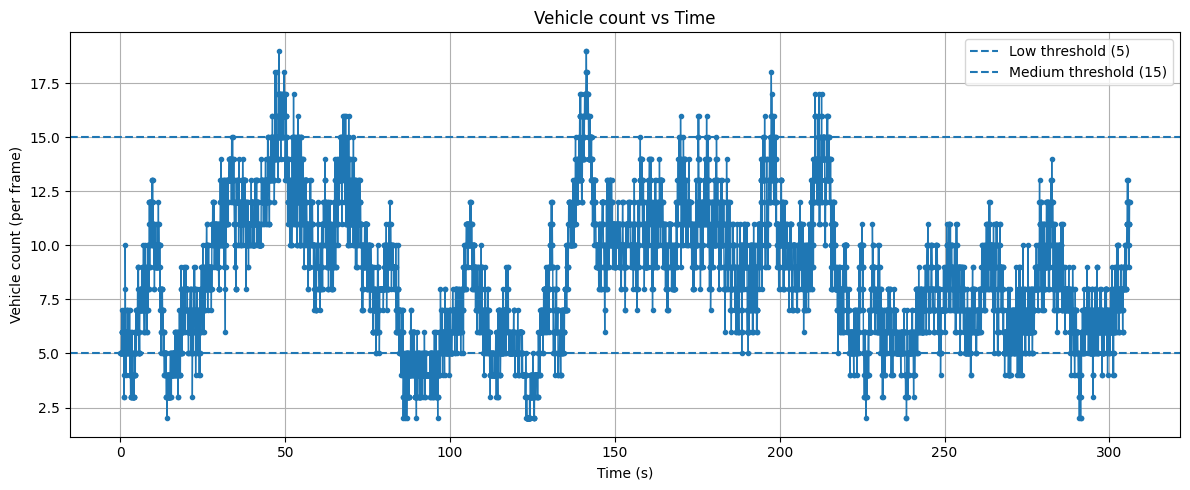

In [6]:
# ----------------------------
# Plot: Vehicle count vs time
# ----------------------------
frames = [x[0] for x in counts_over_time]
times = [x[1] for x in counts_over_time]
totals = [x[2] for x in counts_over_time]
densities = [x[3] for x in counts_over_time]

plt.figure(figsize=(12,5))
plt.plot(times, totals, marker='o', linewidth=1, markersize=3)
plt.title("Vehicle count vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Vehicle count (per frame)")
# Highlight density thresholds
low_thr = DENSITY_THRESHOLDS["low"]
med_thr = DENSITY_THRESHOLDS["medium"]
plt.axhline(low_thr, linestyle='--', label=f"Low threshold ({low_thr})")
plt.axhline(med_thr, linestyle='--', label=f"Medium threshold ({med_thr})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vehicle_count_timeseries.png", dpi=200)
print("Plot saved to vehicle_count_timeseries.png")
plt.show()

In [7]:
!pip install ultralytics opencv-python-headless matplotlib tqdm


In [8]:
VIDEO_PATH = "/content/drive/MyDrive/input_video.mp4"        # Your input video
OUTPUT_VIDEO = "output_annotated.mp4"   # Annotated video will be saved here
MODEL_WEIGHTS = "yolov8n.pt"            # Use small YOLO model for speed


Loading YOLO model: yolov8n.pt
Video opened: /content/drive/MyDrive/input_video.mp4 (frames=9187, fps=30.0, size=1280x720)


Processing frames: 100%|█████████▉| 9184/9188 [04:04<00:00, 37.60it/s]


Processing complete. Processed frames: 9184
Annotated video saved to: output_annotated.mp4
Counts CSV saved to: vehicle_counts.csv
Plot saved to vehicle_count_timeseries.png


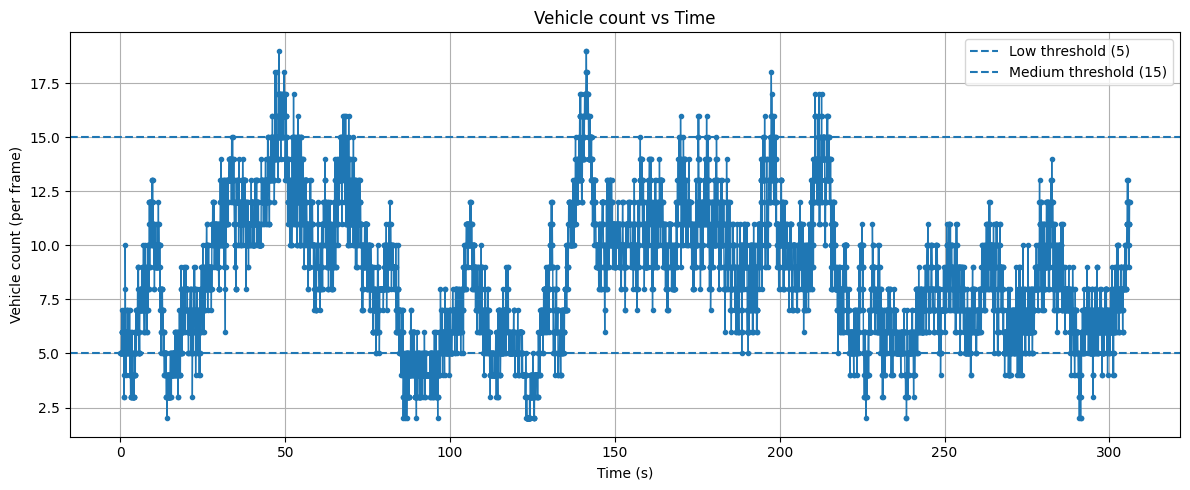

In [9]:
"""
Traffic Density Estimation using YOLOv8 (Ultralytics)

Requirements:
- Python 3.8+
- pip install ultralytics opencv-python-headless matplotlib numpy tqdm

If you have a GPU, make sure ultralytics sees it (CUDA installed) and set device='cuda' in config.
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm
import csv
from datetime import timedelta


# Density thresholds (tunable to your scene)
DENSITY_THRESHOLDS = {
    "low": 5,
    "medium": 15,  # <= medium threshold considered medium; > medium => high
}

# Classes of interest (COCO default class names indices):
# COCO names: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/yolo/data/coco.yaml
# We'll map to vehicle classes.
VEHICLE_CLASS_NAMES = ["car", "motorcycle", "bus", "truck", "bicycle"]  # optionally include 'person' if needed

# ----------------------------
# Helper functions
# ----------------------------
def classify_density(total_count, thresholds=DENSITY_THRESHOLDS):
    if total_count <= thresholds["low"]:
        return "LOW"
    elif total_count <= thresholds["medium"]:
        return "MEDIUM"
    else:
        return "HIGH"

def draw_overlay(frame, bbox, cls_name, conf, color=(0,255,0)):
    # bbox = [x1,y1,x2,y2]
    x1, y1, x2, y2 = [int(v) for v in bbox]
    cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
    label = f"{cls_name} {conf:.2f}"
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(frame, (x1, y1 - 18), (x1 + w, y1), color, -1)
    cv2.putText(frame, label, (x1, y1 - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ----------------------------
# Load model
# ----------------------------
print("Loading YOLO model:", MODEL_WEIGHTS)
model = YOLO(MODEL_WEIGHTS)  # automatically loads weights
# Set model config (confidence threshold) - we will filter results manually too
# model.conf = CONF_THRESH  # (alternative to manual filtering)

# ----------------------------
# Prepare video I/O
# ----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video file {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps / SAMPLE_EVERY_N_FRAMES, (width, height))

print(f"Video opened: {VIDEO_PATH} (frames={total_frames}, fps={fps}, size={width}x{height})")

# Load COCO names if possible (Ultralytics may have built-in names)
COCO_NAMES = model.names if hasattr(model, 'names') else None
if COCO_NAMES is None:
    COCO_NAMES = {0: 'person'}  # fallback; but ultralytics usually provides names

# Map desired vehicle class indices
vehicle_class_ids = [i for i, n in COCO_NAMES.items() if n in VEHICLE_CLASS_NAMES]

# Prepare CSV
csv_file = open(CSV_OUTPUT, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["frame_idx", "time_s", "car_count", "motorcycle_count", "bus_count", "truck_count", "bicycle_count", "total_count", "density"])

# Process frames
frame_idx = 0
processed = 0
counts_over_time = []

pbar = tqdm(total=total_frames // SAMPLE_EVERY_N_FRAMES + 1, desc="Processing frames")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    if (frame_idx - 1) % SAMPLE_EVERY_N_FRAMES != 0:
        continue

    # Inference
    # Note: ultralytics model can accept numpy BGR images directly
    results = model.predict(source=frame, conf=CONF_THRESH, device=DEVICE, imgsz=640, verbose=False)

    # results is a list; take the first
    res = results[0]
    boxes = getattr(res, 'boxes', None)
    car_count = motorcycle_count = bus_count = truck_count = bicycle_count = 0

    # Draw detections
    if boxes is not None and len(boxes) > 0:
        # boxes.boxes: xyxy, boxes.cls, boxes.conf in new versions. Use attributes robustly.
        # Get arrays safely
        xyxy = boxes.xyxy.cpu().numpy() if hasattr(boxes, 'xyxy') else np.array([])
        cls_ids = boxes.cls.cpu().numpy().astype(int) if hasattr(boxes, 'cls') else np.array([])
        confidences = boxes.conf.cpu().numpy() if hasattr(boxes, 'conf') else np.array([])

        for i, (b, cls_id, conf) in enumerate(zip(xyxy, cls_ids, confidences)):
            x1, y1, x2, y2 = b
            area = (x2 - x1) * (y2 - y1)
            if area < MIN_BOX_AREA:  # ignore tiny boxes
                continue
            cls_name = COCO_NAMES.get(int(cls_id), str(cls_id))
            # Count vehicle classes
            if cls_name == 'car':
                car_count += 1
            elif cls_name == 'motorcycle':
                motorcycle_count += 1
            elif cls_name == 'bus':
                bus_count += 1
            elif cls_name == 'truck':
                truck_count += 1
            elif cls_name == 'bicycle':
                bicycle_count += 1
            # draw
            draw_overlay(frame, b, cls_name, float(conf))

    total_count = car_count + motorcycle_count + bus_count + truck_count + bicycle_count
    density_label = classify_density(total_count)

    # Overlay counts and density on frame
    info_text = f"Frame: {frame_idx}  Vehicles: {total_count}  Density: {density_label}"
    cv2.putText(frame, info_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 4, cv2.LINE_AA)
    cv2.putText(frame, info_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_AA)

    # Add colored density band
    if density_label == "LOW":
        band_color = (0, 255, 0)
    elif density_label == "MEDIUM":
        band_color = (0, 215, 255)
    else:
        band_color = (0, 0, 255)
    cv2.rectangle(frame, (0, height-40), (width, height), band_color, -1)
    cv2.putText(frame, f"Density: {density_label}", (10, height-12), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_AA)

    # Write frame to output video
    out_vid.write(frame)

    # Record counts
    time_s = frame_idx / fps
    csv_writer.writerow([frame_idx, f"{time_s:.3f}", car_count, motorcycle_count, bus_count, truck_count, bicycle_count, total_count, density_label])
    counts_over_time.append((frame_idx, time_s, total_count, density_label))

    processed += 1
    pbar.update(1)

pbar.close()
csv_file.close()
cap.release()
out_vid.release()
print(f"Processing complete. Processed frames: {processed}")
print(f"Annotated video saved to: {OUTPUT_VIDEO}")
print(f"Counts CSV saved to: {CSV_OUTPUT}")

# ----------------------------
# Plot: Vehicle count vs time
# ----------------------------
frames = [x[0] for x in counts_over_time]
times = [x[1] for x in counts_over_time]
totals = [x[2] for x in counts_over_time]
densities = [x[3] for x in counts_over_time]

plt.figure(figsize=(12,5))
plt.plot(times, totals, marker='o', linewidth=1, markersize=3)
plt.title("Vehicle count vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Vehicle count (per frame)")
# Highlight density thresholds
low_thr = DENSITY_THRESHOLDS["low"]
med_thr = DENSITY_THRESHOLDS["medium"]
plt.axhline(low_thr, linestyle='--', label=f"Low threshold ({low_thr})")
plt.axhline(med_thr, linestyle='--', label=f"Medium threshold ({med_thr})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vehicle_count_timeseries.png", dpi=200)
print("Plot saved to vehicle_count_timeseries.png")
plt.show()
